<a href="https://colab.research.google.com/github/jscienciadados/ciencia-dados/blob/main/GloVe_Busca_por_Similaridade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color="blue">Machine Learning</font>

#<font color="DodgerBlue">Processamento de Linguagem Natural</font>

# Estudo de Caso - Buscador de Palavras em Texto por Similaridade

In [1]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable
from nltk.tokenize import word_tokenize
%matplotlib inline
torch.manual_seed(1)

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Carregando e Processando os Dados
Para este estudo de caso, usaremos o famoso texto de Isaac Asimov: The Last Question.

http://users.ece.cmu.edu/~gamvrosi/thelastq.html

Traduzimos o texto e usaremos para treinar o modelo GloVe e depois buscar palavras por similaridade. Recomendados a leitura do arquivo asimov.txt (usado na célula abaixo) antes de executar o restante do Jupyter Notebook

In [5]:
# Abre o arquivo para leitura e carrega na variavel arquivo_texto
arquivo_texto = open('dados/asimov.txt', 'r')

In [6]:
# Converte as palavras para minusculo
texto = arquivo_texto.read().lower()

In [7]:
# Fecha o arquivo_texto
arquivo_texto.close()

In [9]:
# Tokenização do texto 
texto_token = word_tokenize(texto)

In [10]:
# Variavel para comprimento total dos tokens
comp_tokens = len(texto_token)

In [11]:
print("Número de Tokens: ", comp_tokens)

Número de Tokens:  5280


#<font color="OrangeRed">Criando Vocabulário</font>

In [12]:
vocab = set(texto_token)
vocab_size = len(vocab)
print("Tamanho do Vocabulário: ", vocab_size)

Tamanho do Vocabulário:  1397


In [13]:
# Dicionario para mapear as palavras aos indices
palavra_indice = {palavra: i for i, palavra in enumerate(vocab)}
palavra_indice

{'resposta': 0,
 'lado': 1,
 'desajeitadas': 2,
 'marte': 3,
 'colegas': 4,
 'sussurrou': 5,
 'simples': 6,
 'apagarem': 7,
 'simplesmente': 8,
 'reconstruir': 9,
 'incrível': 10,
 'incontável': 11,
 'interestelar': 12,
 'conseguiria': 13,
 'que': 14,
 'dedicado': 15,
 'virtualmente': 16,
 'globo': 17,
 'fundir-se': 18,
 'subterrâneas': 19,
 'insuficientes.': 20,
 'descansar': 21,
 'computador': 22,
 'extremidade': 23,
 'suponho': 24,
 'plano': 25,
 'momentos': 26,
 'seu': 27,
 'maior': 28,
 'vamos': 29,
 'assim': 30,
 'gelo': 31,
 'geométrica': 32,
 'jeito': 33,
 'imortais': 34,
 'proporções.': 35,
 'nível': 36,
 'com': 37,
 'transformar': 38,
 'alguma': 39,
 'enormes': 40,
 'progressão': 41,
 'expandido': 42,
 'fria': 43,
 'existir': 44,
 'componentes': 45,
 'início': 46,
 'terra.': 47,
 'mãe': 48,
 'restos': 49,
 'merecer': 50,
 'povoado.': 51,
 'nem': 52,
 'leve': 53,
 'encheremos': 54,
 'alexander': 55,
 'bom': 56,
 'resultado': 57,
 'inserida': 58,
 'velhas': 59,
 'à': 60,
 'solu

In [14]:
# Dicionario para mapear os indices as palavras
indice_palavra = {i: palavra for i, palavra in enumerate(vocab)}
indice_palavra

{0: 'resposta',
 1: 'lado',
 2: 'desajeitadas',
 3: 'marte',
 4: 'colegas',
 5: 'sussurrou',
 6: 'simples',
 7: 'apagarem',
 8: 'simplesmente',
 9: 'reconstruir',
 10: 'incrível',
 11: 'incontável',
 12: 'interestelar',
 13: 'conseguiria',
 14: 'que',
 15: 'dedicado',
 16: 'virtualmente',
 17: 'globo',
 18: 'fundir-se',
 19: 'subterrâneas',
 20: 'insuficientes.',
 21: 'descansar',
 22: 'computador',
 23: 'extremidade',
 24: 'suponho',
 25: 'plano',
 26: 'momentos',
 27: 'seu',
 28: 'maior',
 29: 'vamos',
 30: 'assim',
 31: 'gelo',
 32: 'geométrica',
 33: 'jeito',
 34: 'imortais',
 35: 'proporções.',
 36: 'nível',
 37: 'com',
 38: 'transformar',
 39: 'alguma',
 40: 'enormes',
 41: 'progressão',
 42: 'expandido',
 43: 'fria',
 44: 'existir',
 45: 'componentes',
 46: 'início',
 47: 'terra.',
 48: 'mãe',
 49: 'restos',
 50: 'merecer',
 51: 'povoado.',
 52: 'nem',
 53: 'leve',
 54: 'encheremos',
 55: 'alexander',
 56: 'bom',
 57: 'resultado',
 58: 'inserida',
 59: 'velhas',
 60: 'à',
 61: '

Salvo indicações em contrario, usamos um contexto de dez palavras a esquerda e dez palavras a direita.

In [15]:
CONTEXT_SIZE = 10

In [16]:
# Matriz de co-ocorrencia preenchida com zeros
co_occ_mat = np.zeros((vocab_size, vocab_size))
co_occ_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Agora percorremos os dicionarios de mapeamento criados anteriormente e preenchemos a matriz de co-ocorrencia.

In [17]:
# Loop externo por todo comprimento do vocabulário
for i in range(comp_tokens):
   
    # Loop interno pelo tamanho do contexto
    for dist in range(1, CONTEXT_SIZE + 1):
       
        # Obtém o índice do token
        ix = palavra_indice[texto_token[i]]
       
        # Se a palara estiver à esquerda, inserimos à esquerda na matriz de co-ocorrência
        if i - dist > 0:
            left_ix = palavra_indice[texto_token[i - dist]]
            co_occ_mat[ix, left_ix] += 1.0 / dist
           
        # Se a palara estiver à direita, inserimos à direita na matriz de co-ocorrência
        if i + dist < len(texto_token):
            right_ix = palavra_indice[texto_token[i + dist]]
            co_occ_mat[ix, right_ix] += 1.0 / dist


In [18]:
co_occ_mat

array([[ 0.25      ,  0.        ,  0.        , ...,  0.        ,
         0.1       ,  3.21111111],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.64285714],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.33333333],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.1       ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.21111111,  0.64285714,  0.33333333, ...,  1.        ,
         0.        , 17.91984127]])

In [19]:
# Transposta da matriz de co-ocorrências
# Retorna um array 2-D com uma linha para cada elemento não-zero
co_occs = np.transpose(np.nonzero(co_occ_mat))


In [20]:
# Print
print("Shape da Matriz de Co-ocorrencia:", co_occ_mat.shape)

Shape da Matriz de Co-ocorrencia: (1397, 1397)


In [21]:
print("Matriz de Co-ocorrencia não-zero:\n", co_occs)

Matriz de Co-ocorrencia não-zero:
 [[   0    0]
 [   0   22]
 [   0   37]
 ...
 [1396 1393]
 [1396 1394]
 [1396 1396]]


#<font color="SlateGray4">Criando o Modelo</font>

In [22]:
# Tamanho da embedding
EMBEDDING_SIZE = 50


In [23]:
# Hiperparâmetros
X_MAX = 100
ALPHA = 0.75
BATCH_SIZE = 32
LEARNING_RATE = 0.05
EPOCHS = 200


In [25]:
 #Classe para o modelo
class Glove(nn.Module):

    # Método construtor
    def __init__(self, vocab_size, comat, embedding_size, x_max, alpha):
        super(Glove, self).__init__()
       
        # Matriz de embeddings com as palavras centrais
        self.embedding_V = nn.Embedding(vocab_size, embedding_size)
       
        # Matriz de embeddings com as palavras de contexto
        self.embedding_U = nn.Embedding(vocab_size, embedding_size)

        # Bias
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
       
        # Inicializa os parâmtetros (pesos que a rede aprende durante o treinamento)
        for params in self.parameters():
            nn.init.uniform_(params, a = -0.5, b = 0.5)
           
        # Define os hiperparâmetros (que controlam o treinamento)
        self.x_max = x_max
        self.alpha = alpha
        self.comat = comat
   
    # Função de forward
    def forward(self, center_word_lookup, context_word_lookup):
       
        # Matrizes embedding de pesos para centro e contexto
        center_embed = self.embedding_V(center_word_lookup)
        target_embed = self.embedding_U(context_word_lookup)

        # Matrizes embedding de bias para centro e contexto
        center_bias = self.v_bias(center_word_lookup).squeeze(1)
        target_bias = self.u_bias(context_word_lookup).squeeze(1)

        # Elementos da matriz de co-ocorrência
        co_occurrences = torch.tensor([self.comat[center_word_lookup[i].item(), context_word_lookup[i].item()]
                                       for i in range(BATCH_SIZE)])
       
        # Carrega os pesos
        weights = torch.tensor([self.weight_fn(var) for var in co_occurrences])

        # Funçã de perda
        loss = torch.sum(torch.pow((torch.sum(center_embed * target_embed, dim = 1)
            + center_bias + target_bias) - torch.log(co_occurrences), 2) * weights)
       
        return loss
       
    # Definição do peso
    def weight_fn(self, x):
        if x < self.x_max:
            return (x / self.x_max) ** self.alpha
        return 1
       
    # Soma de V e U como nossos vetores de palavras
    def embeddings(self):
        return self.embedding_V.weight.data + self.embedding_U.weight.data


In [26]:
# Função para gerar um bacth de palavras
def gera_batch(model, batch_size = BATCH_SIZE):
   
    # Extrai uma amostra
    sample = np.random.choice(np.arange(len(co_occs)), size = batch_size, replace = False)
   
    # Listas de vetores
    v_vecs_ix, u_vecs_ix = [], []
   
    # Loop pela amostra para gerar os vetores
    for chosen in sample:
        ind = tuple(co_occs[chosen])  
       
        lookup_ix_v = ind[0]
        lookup_ix_u = ind[1]
       
        v_vecs_ix.append(lookup_ix_v)
        u_vecs_ix.append(lookup_ix_u)
       
    return torch.tensor(v_vecs_ix), torch.tensor(u_vecs_ix)

#<font color="Brown1">Treinamento do Modelo</font>

In [27]:
# Função para o treinamento
def treina_glove(comat):
   
    # Lista para os erros
    losses = []
   
    # Cria o modelo Glove
    model = Glove(vocab_size, comat, embedding_size = EMBEDDING_SIZE, x_max = X_MAX, alpha = ALPHA)
   
    # Otimizador
    optimizer = optim.Adagrad(model.parameters(), lr = LEARNING_RATE)
   
    # Loop pelo número de épocas
    for epoch in range(EPOCHS):
       
        # Erro total
        total_loss = 0
       
        # Número de bacthes
        num_batches = int(len(texto_token) / BATCH_SIZE)
       
        # Loop pelos batches
        for batch in tqdm(range(num_batches)):
           
            # Zera os gradientes do modelo
            model.zero_grad()
           
            # Obtém o bacth de dados
            data = gera_batch(model, BATCH_SIZE)
           
            # Calcula o erro
            loss = model(*data)
           
            # Executa o backpropagation
            loss.backward()
           
            # Otimiza os pesos (aqui é onde ocorre o aprendizado)
            optimizer.step()
           
            # Erro total para a epoch
            total_loss += loss.item()
           
        # Erros do modelo
        losses.append(total_loss)
       
        # Print da epoch e erro médio do modelo
        print('Epoch : %d, Erro Médio : %.02f' % (epoch, np.mean(losses)))
       
    return model, losses 


In [28]:
# Executa a função de treinamento e retorna o modelo e os erros
model, losses = treina_glove(co_occ_mat)

 13%|█▎        | 21/165 [00:00<00:00, 205.89it/s]

Epoch : 0, Erro Médio : 222.38


 15%|█▌        | 25/165 [00:00<00:00, 243.99it/s]

Epoch : 1, Erro Médio : 193.19


 15%|█▍        | 24/165 [00:00<00:00, 236.01it/s]

Epoch : 2, Erro Médio : 187.00


 15%|█▌        | 25/165 [00:00<00:00, 243.02it/s]

Epoch : 3, Erro Médio : 176.34


 15%|█▍        | 24/165 [00:00<00:00, 236.55it/s]

Epoch : 4, Erro Médio : 175.58


 13%|█▎        | 21/165 [00:00<00:00, 209.87it/s]

Epoch : 5, Erro Médio : 169.27


 15%|█▍        | 24/165 [00:00<00:00, 234.38it/s]

Epoch : 6, Erro Médio : 162.83


 13%|█▎        | 21/165 [00:00<00:00, 209.74it/s]

Epoch : 7, Erro Médio : 158.25


 15%|█▍        | 24/165 [00:00<00:00, 238.35it/s]

Epoch : 8, Erro Médio : 153.34


 14%|█▍        | 23/165 [00:00<00:00, 221.98it/s]

Epoch : 9, Erro Médio : 149.92


 15%|█▍        | 24/165 [00:00<00:00, 236.20it/s]

Epoch : 10, Erro Médio : 148.13


 15%|█▌        | 25/165 [00:00<00:00, 248.07it/s]

Epoch : 11, Erro Médio : 145.52


 14%|█▍        | 23/165 [00:00<00:00, 224.61it/s]

Epoch : 12, Erro Médio : 141.24


 15%|█▍        | 24/165 [00:00<00:00, 235.50it/s]

Epoch : 13, Erro Médio : 138.21


 15%|█▌        | 25/165 [00:00<00:00, 244.20it/s]

Epoch : 14, Erro Médio : 135.30


 15%|█▌        | 25/165 [00:00<00:00, 241.02it/s]

Epoch : 15, Erro Médio : 132.42


 15%|█▍        | 24/165 [00:00<00:00, 235.63it/s]

Epoch : 16, Erro Médio : 129.33


 14%|█▍        | 23/165 [00:00<00:00, 229.32it/s]

Epoch : 17, Erro Médio : 126.40


 15%|█▍        | 24/165 [00:00<00:00, 238.79it/s]

Epoch : 18, Erro Médio : 124.03


 14%|█▍        | 23/165 [00:00<00:00, 229.25it/s]

Epoch : 19, Erro Médio : 121.33


 15%|█▍        | 24/165 [00:00<00:00, 233.04it/s]

Epoch : 20, Erro Médio : 118.77


 13%|█▎        | 22/165 [00:00<00:00, 214.38it/s]

Epoch : 21, Erro Médio : 116.34


 15%|█▍        | 24/165 [00:00<00:00, 237.80it/s]

Epoch : 22, Erro Médio : 114.34


 13%|█▎        | 22/165 [00:00<00:00, 218.14it/s]

Epoch : 23, Erro Médio : 112.48


 15%|█▌        | 25/165 [00:00<00:00, 243.26it/s]

Epoch : 24, Erro Médio : 110.37


 15%|█▌        | 25/165 [00:00<00:00, 243.97it/s]

Epoch : 25, Erro Médio : 108.52


 15%|█▍        | 24/165 [00:00<00:00, 237.74it/s]

Epoch : 26, Erro Médio : 106.65


 13%|█▎        | 22/165 [00:00<00:00, 217.84it/s]

Epoch : 27, Erro Médio : 104.73


 15%|█▌        | 25/165 [00:00<00:00, 241.14it/s]

Epoch : 28, Erro Médio : 103.03


 14%|█▍        | 23/165 [00:00<00:00, 226.97it/s]

Epoch : 29, Erro Médio : 101.41


 14%|█▍        | 23/165 [00:00<00:00, 227.63it/s]

Epoch : 30, Erro Médio : 99.78


 14%|█▍        | 23/165 [00:00<00:00, 224.41it/s]

Epoch : 31, Erro Médio : 98.20


 13%|█▎        | 21/165 [00:00<00:00, 206.86it/s]

Epoch : 32, Erro Médio : 96.66


 14%|█▍        | 23/165 [00:00<00:00, 229.92it/s]

Epoch : 33, Erro Médio : 95.31


 13%|█▎        | 22/165 [00:00<00:00, 215.88it/s]

Epoch : 34, Erro Médio : 93.93


 15%|█▍        | 24/165 [00:00<00:00, 239.80it/s]

Epoch : 35, Erro Médio : 92.56


 14%|█▍        | 23/165 [00:00<00:00, 227.57it/s]

Epoch : 36, Erro Médio : 91.24


 15%|█▌        | 25/165 [00:00<00:00, 242.58it/s]

Epoch : 37, Erro Médio : 90.05


 13%|█▎        | 22/165 [00:00<00:00, 217.56it/s]

Epoch : 38, Erro Médio : 88.86


 15%|█▌        | 25/165 [00:00<00:00, 242.06it/s]

Epoch : 39, Erro Médio : 87.69


 13%|█▎        | 22/165 [00:00<00:00, 211.53it/s]

Epoch : 40, Erro Médio : 86.54


 15%|█▌        | 25/165 [00:00<00:00, 248.63it/s]

Epoch : 41, Erro Médio : 85.42


 13%|█▎        | 21/165 [00:00<00:00, 205.80it/s]

Epoch : 42, Erro Médio : 84.44


 14%|█▍        | 23/165 [00:00<00:00, 229.45it/s]

Epoch : 43, Erro Médio : 83.46


 15%|█▌        | 25/165 [00:00<00:00, 245.86it/s]

Epoch : 44, Erro Médio : 82.45


 15%|█▍        | 24/165 [00:00<00:00, 238.55it/s]

Epoch : 45, Erro Médio : 81.55


 13%|█▎        | 22/165 [00:00<00:00, 215.88it/s]

Epoch : 46, Erro Médio : 80.62


 15%|█▌        | 25/165 [00:00<00:00, 243.36it/s]

Epoch : 47, Erro Médio : 79.68


 14%|█▍        | 23/165 [00:00<00:00, 226.66it/s]

Epoch : 48, Erro Médio : 78.87


 13%|█▎        | 22/165 [00:00<00:00, 219.69it/s]

Epoch : 49, Erro Médio : 78.04


 14%|█▍        | 23/165 [00:00<00:00, 223.62it/s]

Epoch : 50, Erro Médio : 77.22


 15%|█▌        | 25/165 [00:00<00:00, 245.06it/s]

Epoch : 51, Erro Médio : 76.40


 16%|█▌        | 26/165 [00:00<00:00, 256.63it/s]

Epoch : 52, Erro Médio : 75.64


 13%|█▎        | 22/165 [00:00<00:00, 216.20it/s]

Epoch : 53, Erro Médio : 74.90


 15%|█▌        | 25/165 [00:00<00:00, 248.49it/s]

Epoch : 54, Erro Médio : 74.17


 15%|█▌        | 25/165 [00:00<00:00, 241.42it/s]

Epoch : 55, Erro Médio : 73.43


 15%|█▌        | 25/165 [00:00<00:00, 242.66it/s]

Epoch : 56, Erro Médio : 72.72


 15%|█▌        | 25/165 [00:00<00:00, 245.24it/s]

Epoch : 57, Erro Médio : 72.02


 15%|█▌        | 25/165 [00:00<00:00, 247.99it/s]

Epoch : 58, Erro Médio : 71.36


 15%|█▌        | 25/165 [00:00<00:00, 242.33it/s]

Epoch : 59, Erro Médio : 70.71


 14%|█▍        | 23/165 [00:00<00:00, 229.64it/s]

Epoch : 60, Erro Médio : 70.05


 13%|█▎        | 22/165 [00:00<00:00, 219.64it/s]

Epoch : 61, Erro Médio : 69.44


 15%|█▌        | 25/165 [00:00<00:00, 244.38it/s]

Epoch : 62, Erro Médio : 68.79


 14%|█▍        | 23/165 [00:00<00:00, 226.76it/s]

Epoch : 63, Erro Médio : 68.18


 15%|█▍        | 24/165 [00:00<00:00, 236.88it/s]

Epoch : 64, Erro Médio : 67.59


 15%|█▌        | 25/165 [00:00<00:00, 245.10it/s]

Epoch : 65, Erro Médio : 67.01


 15%|█▍        | 24/165 [00:00<00:00, 232.30it/s]

Epoch : 66, Erro Médio : 66.44


 13%|█▎        | 22/165 [00:00<00:00, 219.89it/s]

Epoch : 67, Erro Médio : 65.91


 15%|█▍        | 24/165 [00:00<00:00, 238.96it/s]

Epoch : 68, Erro Médio : 65.35


 15%|█▌        | 25/165 [00:00<00:00, 246.17it/s]

Epoch : 69, Erro Médio : 64.85


 15%|█▌        | 25/165 [00:00<00:00, 249.91it/s]

Epoch : 70, Erro Médio : 64.35


 15%|█▍        | 24/165 [00:00<00:00, 232.79it/s]

Epoch : 71, Erro Médio : 63.83


 15%|█▌        | 25/165 [00:00<00:00, 246.76it/s]

Epoch : 72, Erro Médio : 63.33


 15%|█▍        | 24/165 [00:00<00:00, 239.42it/s]

Epoch : 73, Erro Médio : 62.83


 14%|█▍        | 23/165 [00:00<00:00, 222.25it/s]

Epoch : 74, Erro Médio : 62.35


 13%|█▎        | 22/165 [00:00<00:00, 219.18it/s]

Epoch : 75, Erro Médio : 61.88


 16%|█▌        | 26/165 [00:00<00:00, 250.82it/s]

Epoch : 76, Erro Médio : 61.42


 14%|█▍        | 23/165 [00:00<00:00, 229.18it/s]

Epoch : 77, Erro Médio : 60.96


 15%|█▍        | 24/165 [00:00<00:00, 237.03it/s]

Epoch : 78, Erro Médio : 60.51


 15%|█▌        | 25/165 [00:00<00:00, 244.83it/s]

Epoch : 79, Erro Médio : 60.06


 14%|█▍        | 23/165 [00:00<00:00, 227.85it/s]

Epoch : 80, Erro Médio : 59.62


 14%|█▍        | 23/165 [00:00<00:00, 225.82it/s]

Epoch : 81, Erro Médio : 59.22


 13%|█▎        | 21/165 [00:00<00:00, 205.57it/s]

Epoch : 82, Erro Médio : 58.81


 15%|█▌        | 25/165 [00:00<00:00, 248.38it/s]

Epoch : 83, Erro Médio : 58.41


 15%|█▌        | 25/165 [00:00<00:00, 243.21it/s]

Epoch : 84, Erro Médio : 58.02


 13%|█▎        | 22/165 [00:00<00:00, 217.10it/s]

Epoch : 85, Erro Médio : 57.62


 15%|█▍        | 24/165 [00:00<00:00, 235.16it/s]

Epoch : 86, Erro Médio : 57.25


 15%|█▍        | 24/165 [00:00<00:00, 219.68it/s]

Epoch : 87, Erro Médio : 56.87


 13%|█▎        | 21/165 [00:00<00:00, 206.71it/s]

Epoch : 88, Erro Médio : 56.49


 15%|█▌        | 25/165 [00:00<00:00, 245.01it/s]

Epoch : 89, Erro Médio : 56.13


 15%|█▍        | 24/165 [00:00<00:00, 235.53it/s]

Epoch : 90, Erro Médio : 55.78


 14%|█▍        | 23/165 [00:00<00:00, 221.91it/s]

Epoch : 91, Erro Médio : 55.43


 14%|█▍        | 23/165 [00:00<00:00, 229.16it/s]

Epoch : 92, Erro Médio : 55.09


 14%|█▍        | 23/165 [00:00<00:00, 221.51it/s]

Epoch : 93, Erro Médio : 54.75


 15%|█▍        | 24/165 [00:00<00:00, 233.08it/s]

Epoch : 94, Erro Médio : 54.42


 15%|█▍        | 24/165 [00:00<00:00, 237.07it/s]

Epoch : 95, Erro Médio : 54.08


 14%|█▍        | 23/165 [00:00<00:00, 222.14it/s]

Epoch : 96, Erro Médio : 53.76


 15%|█▍        | 24/165 [00:00<00:00, 238.11it/s]

Epoch : 97, Erro Médio : 53.44


 15%|█▌        | 25/165 [00:00<00:00, 247.75it/s]

Epoch : 98, Erro Médio : 53.12


 15%|█▍        | 24/165 [00:00<00:00, 230.73it/s]

Epoch : 99, Erro Médio : 52.80


 14%|█▍        | 23/165 [00:00<00:00, 224.22it/s]

Epoch : 100, Erro Médio : 52.50


 15%|█▌        | 25/165 [00:00<00:00, 242.22it/s]

Epoch : 101, Erro Médio : 52.20


 13%|█▎        | 22/165 [00:00<00:00, 219.56it/s]

Epoch : 102, Erro Médio : 51.90


 15%|█▌        | 25/165 [00:00<00:00, 242.00it/s]

Epoch : 103, Erro Médio : 51.60


 15%|█▍        | 24/165 [00:00<00:00, 237.72it/s]

Epoch : 104, Erro Médio : 51.31


 13%|█▎        | 21/165 [00:00<00:00, 203.03it/s]

Epoch : 105, Erro Médio : 51.03


 14%|█▍        | 23/165 [00:00<00:00, 223.64it/s]

Epoch : 106, Erro Médio : 50.75


 15%|█▍        | 24/165 [00:00<00:00, 234.06it/s]

Epoch : 107, Erro Médio : 50.47


 15%|█▍        | 24/165 [00:00<00:00, 236.85it/s]

Epoch : 108, Erro Médio : 50.20


 12%|█▏        | 20/165 [00:00<00:00, 195.26it/s]

Epoch : 109, Erro Médio : 49.92


 16%|█▌        | 26/165 [00:00<00:00, 249.08it/s]

Epoch : 110, Erro Médio : 49.65


 14%|█▍        | 23/165 [00:00<00:00, 229.55it/s]

Epoch : 111, Erro Médio : 49.39


 15%|█▌        | 25/165 [00:00<00:00, 242.23it/s]

Epoch : 112, Erro Médio : 49.13


 15%|█▌        | 25/165 [00:00<00:00, 242.82it/s]

Epoch : 113, Erro Médio : 48.87


 15%|█▌        | 25/165 [00:00<00:00, 243.37it/s]

Epoch : 114, Erro Médio : 48.62


 14%|█▍        | 23/165 [00:00<00:00, 226.42it/s]

Epoch : 115, Erro Médio : 48.37


 12%|█▏        | 20/165 [00:00<00:00, 195.49it/s]

Epoch : 116, Erro Médio : 48.12


 14%|█▍        | 23/165 [00:00<00:00, 228.46it/s]

Epoch : 117, Erro Médio : 47.87


 15%|█▌        | 25/165 [00:00<00:00, 245.58it/s]

Epoch : 118, Erro Médio : 47.63


 15%|█▍        | 24/165 [00:00<00:00, 236.63it/s]

Epoch : 119, Erro Médio : 47.38


 14%|█▍        | 23/165 [00:00<00:00, 221.05it/s]

Epoch : 120, Erro Médio : 47.15


 14%|█▍        | 23/165 [00:00<00:00, 222.39it/s]

Epoch : 121, Erro Médio : 46.92


 14%|█▍        | 23/165 [00:00<00:00, 224.86it/s]

Epoch : 122, Erro Médio : 46.69


 13%|█▎        | 22/165 [00:00<00:00, 215.09it/s]

Epoch : 123, Erro Médio : 46.46


 14%|█▍        | 23/165 [00:00<00:00, 222.38it/s]

Epoch : 124, Erro Médio : 46.24


 14%|█▍        | 23/165 [00:00<00:00, 228.60it/s]

Epoch : 125, Erro Médio : 46.01


 15%|█▍        | 24/165 [00:00<00:00, 234.62it/s]

Epoch : 126, Erro Médio : 45.79


 15%|█▍        | 24/165 [00:00<00:00, 232.75it/s]

Epoch : 127, Erro Médio : 45.57


 14%|█▍        | 23/165 [00:00<00:00, 223.91it/s]

Epoch : 128, Erro Médio : 45.36


 15%|█▌        | 25/165 [00:00<00:00, 241.38it/s]

Epoch : 129, Erro Médio : 45.15


 14%|█▍        | 23/165 [00:00<00:00, 226.01it/s]

Epoch : 130, Erro Médio : 44.93


 15%|█▍        | 24/165 [00:00<00:00, 232.61it/s]

Epoch : 131, Erro Médio : 44.73


 14%|█▍        | 23/165 [00:00<00:00, 228.61it/s]

Epoch : 132, Erro Médio : 44.52


 15%|█▌        | 25/165 [00:00<00:00, 242.10it/s]

Epoch : 133, Erro Médio : 44.31


 14%|█▍        | 23/165 [00:00<00:00, 229.79it/s]

Epoch : 134, Erro Médio : 44.11


 15%|█▍        | 24/165 [00:00<00:00, 232.74it/s]

Epoch : 135, Erro Médio : 43.91


 13%|█▎        | 22/165 [00:00<00:00, 217.56it/s]

Epoch : 136, Erro Médio : 43.71


 15%|█▌        | 25/165 [00:00<00:00, 244.46it/s]

Epoch : 137, Erro Médio : 43.52


 15%|█▍        | 24/165 [00:00<00:00, 237.78it/s]

Epoch : 138, Erro Médio : 43.32


 14%|█▍        | 23/165 [00:00<00:00, 226.72it/s]

Epoch : 139, Erro Médio : 43.13


 15%|█▍        | 24/165 [00:00<00:00, 230.89it/s]

Epoch : 140, Erro Médio : 42.94


 14%|█▍        | 23/165 [00:00<00:00, 229.18it/s]

Epoch : 141, Erro Médio : 42.75


 15%|█▍        | 24/165 [00:00<00:00, 231.19it/s]

Epoch : 142, Erro Médio : 42.57


 15%|█▍        | 24/165 [00:00<00:00, 230.92it/s]

Epoch : 143, Erro Médio : 42.39


 15%|█▍        | 24/165 [00:00<00:00, 239.19it/s]

Epoch : 144, Erro Médio : 42.21


 15%|█▍        | 24/165 [00:00<00:00, 233.85it/s]

Epoch : 145, Erro Médio : 42.02


 15%|█▍        | 24/165 [00:00<00:00, 228.14it/s]

Epoch : 146, Erro Médio : 41.84


 15%|█▌        | 25/165 [00:00<00:00, 245.73it/s]

Epoch : 147, Erro Médio : 41.66


 15%|█▍        | 24/165 [00:00<00:00, 238.99it/s]

Epoch : 148, Erro Médio : 41.49


 15%|█▍        | 24/165 [00:00<00:00, 230.79it/s]

Epoch : 149, Erro Médio : 41.32


 13%|█▎        | 22/165 [00:00<00:00, 217.01it/s]

Epoch : 150, Erro Médio : 41.15


 14%|█▍        | 23/165 [00:00<00:00, 226.15it/s]

Epoch : 151, Erro Médio : 40.98


 14%|█▍        | 23/165 [00:00<00:00, 221.03it/s]

Epoch : 152, Erro Médio : 40.82


 13%|█▎        | 21/165 [00:00<00:00, 204.63it/s]

Epoch : 153, Erro Médio : 40.65


 13%|█▎        | 21/165 [00:00<00:00, 208.21it/s]

Epoch : 154, Erro Médio : 40.48


 15%|█▍        | 24/165 [00:00<00:00, 233.45it/s]

Epoch : 155, Erro Médio : 40.32


 13%|█▎        | 22/165 [00:00<00:00, 213.69it/s]

Epoch : 156, Erro Médio : 40.16


 14%|█▍        | 23/165 [00:00<00:00, 224.68it/s]

Epoch : 157, Erro Médio : 40.00


 15%|█▌        | 25/165 [00:00<00:00, 243.31it/s]

Epoch : 158, Erro Médio : 39.85


 13%|█▎        | 21/165 [00:00<00:00, 204.46it/s]

Epoch : 159, Erro Médio : 39.69


 15%|█▍        | 24/165 [00:00<00:00, 234.39it/s]

Epoch : 160, Erro Médio : 39.54


 14%|█▍        | 23/165 [00:00<00:00, 227.81it/s]

Epoch : 161, Erro Médio : 39.38


 15%|█▌        | 25/165 [00:00<00:00, 241.97it/s]

Epoch : 162, Erro Médio : 39.23


 14%|█▍        | 23/165 [00:00<00:00, 225.29it/s]

Epoch : 163, Erro Médio : 39.08


 12%|█▏        | 20/165 [00:00<00:00, 199.54it/s]

Epoch : 164, Erro Médio : 38.93


 13%|█▎        | 21/165 [00:00<00:00, 209.95it/s]

Epoch : 165, Erro Médio : 38.78


 14%|█▍        | 23/165 [00:00<00:00, 226.91it/s]

Epoch : 166, Erro Médio : 38.63


 15%|█▍        | 24/165 [00:00<00:00, 238.18it/s]

Epoch : 167, Erro Médio : 38.49


 15%|█▌        | 25/165 [00:00<00:00, 244.03it/s]

Epoch : 168, Erro Médio : 38.35


 14%|█▍        | 23/165 [00:00<00:00, 223.63it/s]

Epoch : 169, Erro Médio : 38.20


 14%|█▍        | 23/165 [00:00<00:00, 226.45it/s]

Epoch : 170, Erro Médio : 38.06


 15%|█▍        | 24/165 [00:00<00:00, 235.55it/s]

Epoch : 171, Erro Médio : 37.92


 12%|█▏        | 19/165 [00:00<00:00, 183.86it/s]

Epoch : 172, Erro Médio : 37.78


 15%|█▍        | 24/165 [00:00<00:00, 231.76it/s]

Epoch : 173, Erro Médio : 37.64


 14%|█▍        | 23/165 [00:00<00:00, 223.91it/s]

Epoch : 174, Erro Médio : 37.51


 13%|█▎        | 22/165 [00:00<00:00, 217.15it/s]

Epoch : 175, Erro Médio : 37.37


 14%|█▍        | 23/165 [00:00<00:00, 225.22it/s]

Epoch : 176, Erro Médio : 37.23


 15%|█▍        | 24/165 [00:00<00:00, 235.88it/s]

Epoch : 177, Erro Médio : 37.10


 14%|█▍        | 23/165 [00:00<00:00, 220.47it/s]

Epoch : 178, Erro Médio : 36.97


 13%|█▎        | 21/165 [00:00<00:00, 207.51it/s]

Epoch : 179, Erro Médio : 36.83


 13%|█▎        | 22/165 [00:00<00:00, 213.77it/s]

Epoch : 180, Erro Médio : 36.71


 15%|█▍        | 24/165 [00:00<00:00, 239.98it/s]

Epoch : 181, Erro Médio : 36.58


 13%|█▎        | 22/165 [00:00<00:00, 216.32it/s]

Epoch : 182, Erro Médio : 36.45


 15%|█▍        | 24/165 [00:00<00:00, 236.04it/s]

Epoch : 183, Erro Médio : 36.32


 14%|█▍        | 23/165 [00:00<00:00, 222.87it/s]

Epoch : 184, Erro Médio : 36.20


 14%|█▍        | 23/165 [00:00<00:00, 225.16it/s]

Epoch : 185, Erro Médio : 36.07


 14%|█▍        | 23/165 [00:00<00:00, 228.38it/s]

Epoch : 186, Erro Médio : 35.94


 14%|█▍        | 23/165 [00:00<00:00, 224.59it/s]

Epoch : 187, Erro Médio : 35.82


 14%|█▍        | 23/165 [00:00<00:00, 224.32it/s]

Epoch : 188, Erro Médio : 35.70


 13%|█▎        | 22/165 [00:00<00:00, 217.43it/s]

Epoch : 189, Erro Médio : 35.58


 12%|█▏        | 20/165 [00:00<00:00, 196.50it/s]

Epoch : 190, Erro Médio : 35.46


 14%|█▍        | 23/165 [00:00<00:00, 226.41it/s]

Epoch : 191, Erro Médio : 35.34


 14%|█▍        | 23/165 [00:00<00:00, 226.80it/s]

Epoch : 192, Erro Médio : 35.22


 13%|█▎        | 22/165 [00:00<00:00, 214.97it/s]

Epoch : 193, Erro Médio : 35.10


 15%|█▍        | 24/165 [00:00<00:00, 226.13it/s]

Epoch : 194, Erro Médio : 34.99


 15%|█▍        | 24/165 [00:00<00:00, 230.10it/s]

Epoch : 195, Erro Médio : 34.87


 15%|█▍        | 24/165 [00:00<00:00, 231.35it/s]

Epoch : 196, Erro Médio : 34.76


 13%|█▎        | 21/165 [00:00<00:00, 201.99it/s]

Epoch : 197, Erro Médio : 34.64


 15%|█▌        | 25/165 [00:00<00:00, 242.99it/s]

Epoch : 198, Erro Médio : 34.53


100%|██████████| 165/165 [00:00<00:00, 227.67it/s]

Epoch : 199, Erro Médio : 34.42


In [29]:
# Função para o plot do erro durante o treinamento
def plot_loss(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Erro')
    plt.title(title)
    plt.figure()


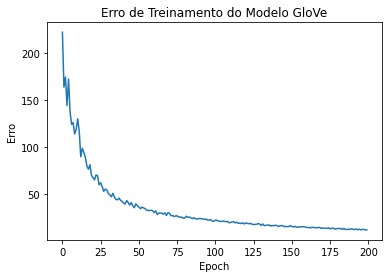

<Figure size 432x288 with 0 Axes>

In [30]:
# plot
plot_loss(losses, "Erro de Treinamento do Modelo GloVe")

#<font color="Goldenrod4">Testando o Modelo:</font> Similaridade de Palavras, analogias de palavras.

In [31]:
# Função que retorna a embedding de uma palavra
def get_palavra(palavra, modelo, word_to_ix):
    return model.embeddings()[word_to_ix[palavra]]


In [32]:
# Função para busca a palavra mais próxima
def busca_palavra_similaridade(vec, word_to_ix, n = 10):
    all_dists = [(w, torch.dist(vec, get_palavra(w, model, palavra_indice))) for w in palavra_indice]
    return sorted(all_dists, key = lambda t: t[1])[:n]


In [33]:
# Gerando o vetor (embedding) de uma palavra
vector = get_palavra("espaço", model, palavra_indice)
print(vector)


tensor([ 0.4385,  0.1841, -0.3503, -0.1503,  0.2263,  0.6643, -0.4738, -0.6454,
         0.0336, -0.1935, -0.7061, -0.0109,  0.4718, -0.5739, -0.6569,  0.2102,
         0.2255,  0.7213, -0.0828,  0.3808,  0.6658, -0.0894, -0.2688,  0.1979,
         0.6250, -0.0094, -0.0996,  0.2365, -0.3256, -0.2984, -0.2787,  0.6225,
        -0.1995,  0.8981,  0.8536,  0.1051,  0.0221, -0.0979,  0.4577, -0.3899,
        -0.0971,  0.2307, -0.1333, -0.8423,  0.0232, -0.1860, -0.4197,  0.1423,
         0.3534, -0.3444])


In [34]:
# Busca palavra similares a palavra  "espaço"
busca_palavra_similaridade(vector, palavra_indice)

[('espaço', tensor(0.)),
 ('mil', tensor(3.3305)),
 ('mais', tensor(3.4054)),
 ('o', tensor(3.4518)),
 ('viagem', tensor(3.4598)),
 ('todo', tensor(3.4741)),
 ('universo', tensor(3.5311)),
 ('luminosa', tensor(3.5523)),
 ('sua', tensor(3.5692)),
 ('este', tensor(3.5721))]

Observe que a palavra "espaço" tem 0 de distância para si mesma. A próxima palavra mais parecida com "espaço" é "universo" e assim por diante. Quanto menor a distância, mais parecida a palavra. Lembrando que a busca por similaridade é feita com as embeddings treinadas com o modelo GloVe.

In [35]:
# Gerando o vetor (embedding) de uma palavra
vector = get_palavra("solar", model, palavra_indice)
print(vector)

tensor([-0.3972,  0.1274, -0.4164,  0.5387, -0.7994, -0.0805,  0.4485,  0.8058,
        -0.6733,  0.1873, -0.4290, -0.1014, -0.4303,  0.2757, -0.2514, -0.2224,
        -0.1183, -0.1058,  0.0336, -0.7615, -0.1999, -0.0399, -1.6824,  0.3879,
        -0.4529,  0.0739, -0.0425, -0.2764,  0.0568, -0.1749,  0.0356, -0.3682,
        -0.7740, -0.7534,  0.5319,  0.3135, -0.1275,  0.5878,  0.1794, -1.1659,
        -0.5796, -0.8526,  0.3383, -0.2131,  0.0187,  0.2018,  0.0903, -0.1483,
         1.2885, -0.1279])


In [36]:
# busca as palavras similares a palavra "solar"
busca_palavra_similaridade(vector, palavra_indice)

[('solar', tensor(0.)),
 ('energia', tensor(2.8767)),
 ('muitos', tensor(3.3140)),
 ('símbolos', tensor(3.7385)),
 ('mentes', tensor(3.7503)),
 ('grande', tensor(3.7612)),
 ('alguma', tensor(3.7824)),
 ('fria', tensor(3.8930)),
 ('computação', tensor(3.9057)),
 ('por', tensor(3.9394))]

A distância da palavra "solar" para si mesma é 0 e a palavra com maior similaridade é "energia" o que faz todo sentido se você leu o texto do Asimov usado para treinar o modelo.


#Analogia



In [37]:
# Função para busca de palavra por analogia
def busca_analogia(p1, p2, p3, n = 5, filtro = True):
   
    # Print
    print('\n[%s : %s :: %s : ?]' % (p1, p2, p3))
   
    # p2 - p1 + p3 = p4
    closest_words = busca_palavra_similaridade(get_palavra(p2, model, palavra_indice) -
                                               get_palavra(p1, model, palavra_indice) +
                                               get_palavra(p3, model, palavra_indice),
                                               palavra_indice)
   
    # Vamos excluir as 3 palavras passadas como parâmetro
    if filtro:
        closest_words = [t for t in closest_words if t[0] not in [p1, p2, p3]]
       
    for tuple in closest_words[:n]:
        print('(%.4f) %s' % (tuple[1], tuple[0]))


In [39]:
# Busca por analogia
busca_analogia("família", "crianças", "humano")



[família : crianças :: humano : ?]
(5.0360) aconteça
(5.2082) explosão
(5.2853) super
(5.3284) solitário
(5.4924) colidirse


#<font color="IndianRed1">Conclusão</font>
E aí estão as palavras que melhor se encaixam na quarta palavra, de acordo com nosso modelo.

Quanto maior a distância, menor a similaridade! Treine o modelo com seus próprios textos e experimente a busca por similaridade.